In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#pip install ISLP

In [7]:
#import necessary modules
import os
import numpy as np
import csv
from tabulate import tabulate
import sys
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ISLP import confusion_table
from functools import partial
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

from statsmodels.api import GLM
from ISLP.models import ModelSpec as MS
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

## regular knn

In [8]:
df = pd.read_csv('/content/drive/My Drive/415/datasci 415/full_dataset.csv')
df['winner_2020_encoded'] = df['winner_2020'].apply(lambda x: 1 if x == 'Democrat' else 0)
df['State'] = df['State'].astype('category')

In [9]:
#all relevant predictors, REMOVE state:
allvars2 = df.columns.drop(['total_votes_2020', 'county_names_with_casing','prop_favored_dem_2020', 'winner_2020', 'County', 'winner_2020_encoded', 'State'])
y = df['winner_2020_encoded']
X = df[allvars2]
for col in X.select_dtypes(include=[bool]).columns:
    X[col] = X[col].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [10]:
# Create the KNN model
knn = KNeighborsClassifier()

# Define the range of k values to search over
param_grid = {'n_neighbors': np.arange(10, 30)}  # From 1 to 20 neighbors

# Use GridSearchCV to search over the hyperparameter grid with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameter and best score
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f"Best k: {best_k}")
print(f"Best cross-validated accuracy: {best_score}")

Best k: 11
Best cross-validated accuracy: 0.8684105891802053


In [11]:
knn1 = KNeighborsClassifier(n_neighbors=best_k)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, y_train)
y_pred = knn1.predict(X_test)
confusion_table(y_pred, y_test)

Truth,0,1
Predicted,,
0,484,76
1,21,47


In [12]:
#try standardizing -- looks a lot better
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled, X_test_scaled = [np.asarray(X) for X in [X_train_scaled, X_test_scaled]]
knn1.fit(X_train_scaled, y_train)
y_pred = knn1.predict(X_test_scaled)
confusion_table(y_pred, y_test)

Truth,0,1
Predicted,,
0,498,33
1,7,90


In [33]:
#final model -- standardized, limited predictors, CV for k
scaler = StandardScaler()
y = df['winner_2020_encoded']
X = df[['prop_favored_dem_2012', 'prop_favored_dem_2016']] #predictors from simple classification selection
for col in X.select_dtypes(include=[bool]).columns:
    X[col] = X[col].astype(int)

X = scaler.fit_transform(X) #X is now standardized

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(10, 30)}  # CV neighbors
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print(f"Best k: {best_k}") #17
print(f"Best cross-validated accuracy: {best_score}")

Best k: 13
Best cross-validated accuracy: 0.9816574023268204


Truth      0.0  1.0
Predicted          
0.0        511    9
1.0          3  105


<function matplotlib.pyplot.show(close=None, block=None)>

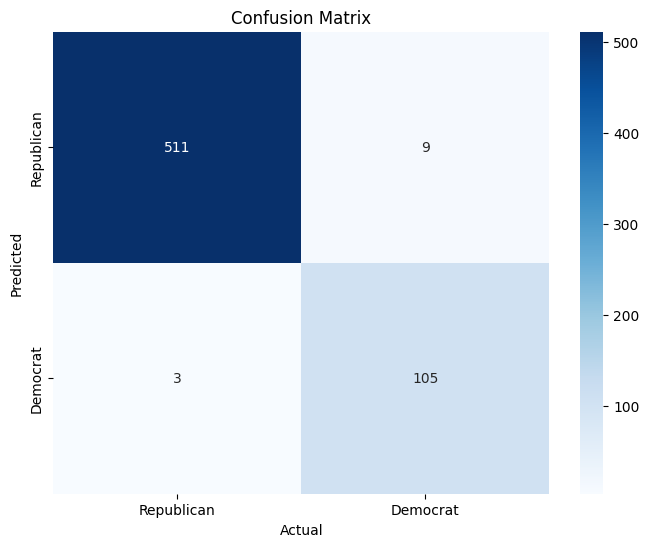

In [34]:
knn1 = KNeighborsClassifier(n_neighbors=best_k)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, y_train)
y_pred = knn1.predict(X_test)
cm = confusion_table(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Republican', 'Democrat'], yticklabels=['Republican', 'Democrat'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show

#model looks really good

## location data

In [15]:
uscounties = pd.read_csv('/content/drive/My Drive/415/datasci 415/uscounties.csv')
df_full = pd.merge(df, uscounties, on='county_fips', how='left')
len(df_full)

3136

In [16]:
df1 = df_full[df_full.isna().any(axis=1)] #missing data rows
df1 = df1[['County', 'State', 'county_names_with_casing', 'county_fips', 'county', 'county_ascii', 'county_full', 'state_id']]
df1

,County,State,county_names_with_casing,county_fips,county,county_ascii,county_full,state_id
889,FAIRFIELD COUNTY,CT,Fairfield County,9001.0,NaN,NaN,NaN,NaN
1211,HARTFORD COUNTY,CT,Hartford County,9003.0,NaN,NaN,NaN,NaN
1671,LITCHFIELD COUNTY,CT,Litchfield County,9005.0,NaN,NaN,NaN,NaN
1892,MIDDLESEX COUNTY,CT,Middlesex County,9007.0,NaN,NaN,NaN,NaN
2040,NEW HAVEN COUNTY,CT,New Haven County,9009.0,NaN,NaN,NaN,NaN
2042,NEW LONDON COUNTY,CT,New London County,9011.0,NaN,NaN,NaN,NaN
2776,TOLLAND COUNTY,CT,Tolland County,9013.0,NaN,NaN,NaN,NaN
3042,WINDHAM COUNTY,CT,Windham County,9015.0,NaN,NaN,NaN,NaN
3129,PRINCE OF WALES-HYDER CENSUS AREA,AK,Prince of Wales-Hyder Census Area,2201.0,NaN,NaN,NaN,NaN
3131,SKAGWAY MUNICIPALITY,AK,Skagway Municipality,2231.0,NaN,NaN,NaN,NaN


In [17]:
#missing alaska rows can be found -> county_names_with_casing = county_full
df1_ak = df1[df1['State'] == 'AK']
df1_ak = df1_ak[['State', 'county_names_with_casing']]
df1_ak = pd.merge(df1_ak, df, on=['county_names_with_casing', 'State'])
df1_ak = pd.merge(df1_ak, uscounties, left_on=['county_names_with_casing', 'State'], right_on=['county_full', 'state_id'], how='left')
df1_ak

,State,county_names_with_casing,County,Age.Percent 65 and Older,Education.Bachelor's Degree or Higher,Education.High School or Higher,Ethnicities.Hispanic or Latino,Ethnicities.White Alone,Ethnicities.White Alone\t not Hispanic or Latino,Housing.Households,...,winner_2020_encoded,county,county_ascii,county_full,county_fips_y,state_id,state_name,lat,lng,population
0,AK,Prince of Wales-Hyder Census Area,PRINCE OF WALES-HYDER CENSUS AREA,18.1,18.3,90.8,3.9,46.5,44.9,2371,...,1,Prince of Wales-Hyder,Prince of Wales-Hyder,Prince of Wales-Hyder Census Area,2198,AK,Alaska,55.8011,-133.0167,5799
1,AK,Skagway Municipality,SKAGWAY MUNICIPALITY,15.8,29.6,94.7,6.7,86.3,80.8,375,...,1,Skagway,Skagway,Skagway Municipality,2230,AK,Alaska,59.5630,-135.3363,1303
2,AK,Wrangell City and Borough,WRANGELL CITY AND BOROUGH,24.5,19.4,86.5,3.0,68.8,66.6,1027,...,0,Wrangell,Wrangell,Wrangell City and Borough,2275,AK,Alaska,56.3323,-132.0221,2134


In [18]:
df_full = df_full[(df_full['State'] != 'AK') | (df_full['county'].notna())]
print(len(df_full))
df_full = pd.concat([df_full, df1_ak])
print(len(df_full))
df_full.drop(['county_fips_x', 'county_fips_y'], axis=1, inplace=True)

3133
3136


In [19]:
#missing CT rows?
#df1[df1['State'] == 'CT'] -- regular df

ct = uscounties[uscounties['state_id'] == 'CT'] #need to manually match them with loc df

In [20]:
#change 'county' column to what i want to match with
ct_counties = ['Tolland County', 'Fairfield County', 'New Haven County', 'Hartford County', 'NA',
               'New London County', 'Middlesex County', 'Litchfield County', 'Windham County']
ct.loc[:, 'county'] = ct_counties
ct #nice

,county,county_ascii,county_full,county_fips,state_id,state_name,lat,lng,population
50,Tolland County,Capitol,Capitol Planning Region,9110,CT,Connecticut,41.8185,-72.5720,977165
108,Fairfield County,Western Connecticut,Western Connecticut Planning Region,9190,CT,Connecticut,41.3225,-73.4475,620666
120,New Haven County,South Central Connecticut,South Central Connecticut Planning Region,9170,CT,Connecticut,41.3613,-72.8445,571298
158,Hartford County,Naugatuck Valley,Naugatuck Valley Planning Region,9140,CT,Connecticut,41.5231,-73.0860,451887
220,NA,Greater Bridgeport,Greater Bridgeport Planning Region,9120,CT,Connecticut,41.2428,-73.2314,326381
252,New London County,Southeastern Connecticut,Southeastern Connecticut Planning Region,9180,CT,Connecticut,41.5023,-72.1000,280293
380,Middlesex County,Lower Connecticut River Valley,Lower Connecticut River Valley Planning Region,9130,CT,Connecticut,41.4500,-72.5073,175244
544,Litchfield County,Northwest Hills,Northwest Hills Planning Region,9160,CT,Connecticut,41.8469,-73.2212,112696
631,Windham County,Northeastern Connecticut,Northeastern Connecticut Planning Region,9150,CT,Connecticut,41.8270,-71.9769,95687


In [21]:
#put ct in big df
ct = pd.merge(df, ct, left_on=['county_names_with_casing', 'State'], right_on=['county', 'state_id'], how='right')
ct = ct.dropna()
ct.drop(['county_fips_y'], axis=1, inplace=True)
ct.rename({'county_fips_x': 'county_fips'}, axis=1, inplace=True)
ct

,County,State,Age.Percent 65 and Older,Education.Bachelor's Degree or Higher,Education.High School or Higher,Ethnicities.Hispanic or Latino,Ethnicities.White Alone,Ethnicities.White Alone\t not Hispanic or Latino,Housing.Households,Housing.Persons per Household,...,winner_2020,winner_2020_encoded,county,county_ascii,county_full,state_id,state_name,lat,lng,population
0,TOLLAND COUNTY,CT,16.3,41.8,95.0,5.9,88.6,83.8,55683.0,2.44,...,Democrat,1.0,Tolland County,Capitol,Capitol Planning Region,CT,Connecticut,41.8185,-72.5720,977165
1,FAIRFIELD COUNTY,CT,16.3,47.9,90.0,20.5,78.4,60.9,340189.0,2.72,...,Democrat,1.0,Fairfield County,Western Connecticut,Western Connecticut Planning Region,CT,Connecticut,41.3225,-73.4475,620666
2,NEW HAVEN COUNTY,CT,17.9,35.0,90.1,19.1,77.3,61.6,330572.0,2.51,...,Democrat,1.0,New Haven County,South Central Connecticut,South Central Connecticut Planning Region,CT,Connecticut,41.3613,-72.8445,571298
3,HARTFORD COUNTY,CT,17.4,38.1,89.7,18.8,74.8,59.9,350408.0,2.48,...,Democrat,1.0,Hartford County,Naugatuck Valley,Naugatuck Valley Planning Region,CT,Connecticut,41.5231,-73.0860,451887
5,NEW LONDON COUNTY,CT,18.8,33.3,92.3,11.1,83.6,75.1,107827.0,2.37,...,Democrat,1.0,New London County,Southeastern Connecticut,Southeastern Connecticut Planning Region,CT,Connecticut,41.5023,-72.1000,280293
6,MIDDLESEX COUNTY,CT,21.0,42.2,94.2,6.6,88.7,83.3,66971.0,2.34,...,Democrat,1.0,Middlesex County,Lower Connecticut River Valley,Lower Connecticut River Valley Planning Region,CT,Connecticut,41.4500,-72.5073,175244
7,LITCHFIELD COUNTY,CT,22.0,35.4,93.0,7.1,93.3,87.4,74143.0,2.41,...,Republican,0.0,Litchfield County,Northwest Hills,Northwest Hills Planning Region,CT,Connecticut,41.8469,-73.2212,112696
8,WINDHAM COUNTY,CT,17.2,24.3,88.4,12.4,92.0,82.0,44953.0,2.47,...,Republican,0.0,Windham County,Northeastern Connecticut,Northeastern Connecticut Planning Region,CT,Connecticut,41.8270,-71.9769,95687


In [22]:
df_full = df_full[(df_full['State'] != 'CT')]
print(len(df_full))
df_full = pd.concat([df_full, ct])
print(len(df_full))

3128
3136


In [23]:
na_per_column = df_full.isna().any()
#print(na_per_column) #sanity check

In [24]:
#df_full.to_csv('/content/drive/My Drive/415/datasci 415/full_dataset_with_location.csv', index=False)

## using location

In [25]:
df = df_full

In [26]:
df.columns

Index(['County', 'State', 'Age.Percent 65 and Older',
       'Education.Bachelor's Degree or Higher',
       'Education.High School or Higher', 'Ethnicities.Hispanic or Latino',
       'Ethnicities.White Alone',
       'Ethnicities.White Alone\t not Hispanic or Latino',
       'Housing.Households', 'Housing.Persons per Household',
       'Income.Median Houseold Income', 'Income.Per Capita Income',
       'Miscellaneous.Foreign Born', 'Miscellaneous.Land Area',
       'Miscellaneous.Language Other than English at Home',
       'Miscellaneous.Living in Same House +1 Years',
       'Miscellaneous.Percent Female', 'Population.2020 Population',
       'Population.2010 Population', 'Population.Population per Square Mile',
       'Employment.Firms.Total', 'Employment.Firms.Women-Owned',
       'Employment.Firms.Men-Owned', 'Employment.Firms.Minority-Owned',
       'Employment.Firms.Nonminority-Owned', 'Employment.Firms.Veteran-Owned',
       'Employment.Firms.Nonveteran-Owned', 'county_names_

In [27]:
y = df['winner_2020_encoded']
X = df[['lat', 'lng']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [28]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(10, 30)}  # From 1 to 20 neighbors
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f"Best k: {best_k}")
print(f"Best cross-validated accuracy: {best_score}")

Best k: 11
Best cross-validated accuracy: 0.8716081780661783


In [29]:
knn1 = KNeighborsClassifier(n_neighbors=best_k)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, y_train)
y_pred = knn1.predict(X_test)
confusion_table(y_pred, y_test)
#using only location does about as well as a regular model with all predictors

Truth,0.0,1.0
Predicted,,
0.0,491,72
1.0,23,42


In [30]:
y = df['winner_2020_encoded']
X = df[['prop_favored_dem_2012', 'prop_favored_dem_2016']]  #its just always best with these two and nothing else

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
knn1 = KNeighborsClassifier(n_neighbors=best_k)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, y_train)
y_pred = knn1.predict(X_test)
confusion_table(y_pred, y_test)

Truth,0.0,1.0
Predicted,,
0.0,505,6
1.0,9,108
